# 앱 이용자 별 향후 이용자수 예측

In [227]:
import pandas as pd
import numpy as np
np.random.seed(42)

In [228]:
traffic_data = pd.read_excel("2020교통량통합.xlsx")
weather_data = pd.read_csv("서울시_기상데이터.csv",encoding='cp949')
db_data = pd.read_csv("실전db.csv",encoding='cp949')


# 트래픽과 웨더에서는 각각 Good,Bad정도로만 나올 수 있게 만들어볼 예정

In [229]:
traffic_data.head()

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0


In [230]:
weather_data.head()

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0


# DB데이터 살펴보기 

In [231]:
db_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [232]:
#datetime으로 변환
db_data['DATE'] = pd.to_datetime(db_data['DATE'])
db_data['JOIN_DATE'] = pd.to_datetime(db_data['JOIN_DATE'])


In [233]:
#한달간 이용건수를 예측해야 하기 때문에 month데이터만 따로 추가
lst = []
for i in db_data['DATE']:
    lst.append(i.month)
db_data['MONTH'] = lst


In [234]:
#STORE_ID는 고유값이기 때문에 문자로 변환
db_data['STORE_ID'] = list(map(str,db_data['STORE_ID']))

# 데이터 살펴보기

In [235]:
#COUNT,STORE_ID,AD1의 종류는 다양하다
print(len(set(db_data['COUNT'])))
print(len(set(db_data['STORE_ID'])))
print(len(set(db_data['AD1'])))

56
1061
85


In [236]:
#D_TYPE과 GOODS_TYPE은 범주가 적어 one-hot encoding 실시할 예정
print(set(db_data['D_TYPE']))
print(set(db_data['GOODS_TYPE']))

{'BB', 'CC', 'AA'}
{'D', 'B', 'C', 'A'}


# db_data를 어떤 형식으로 만들어야 머신러닝을 돌릴 수 있을까?
* ID기준으로 묶으면 좋을거 같긴 한데 그러면 shape가 애매해질 거 같음

In [237]:
#데이터 살펴보기
db_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1


## USER_ID를 기준으로 데이터 살펴보기
* 하나 이상의 거래를 한 고객을 뽑아서 눈으로 살펴보자

In [238]:
#고객별로 몇개의 거래를 했는지
db_data['USER_ID'].value_counts() #value_counts(): 기억했다가 다음에 써먹으면 좋을 유용한 함수

999665     366
591610     244
1355841    235
1407916    222
1224426    222
          ... 
586251       1
1575444      1
1573397      1
1591836      1
30735        1
Name: USER_ID, Length: 165425, dtype: int64

In [239]:
db_data[db_data['USER_ID'] == 33314] #예시1 - 임의로 찾아본 고객

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1
235563,33314,2014-11-20,BB,220077,C,2020-05-01,1,JRR,5
239229,33314,2014-11-20,BB,220914,A,2020-05-03,1,GS,5


In [240]:
db_data[db_data['USER_ID'] == 999665] #예시2 - 거래가 가장 많은 고객(매일 거래했다고 추정됨)

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,1
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,1
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC,1
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP,1
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN,1
...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY,12
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J,12
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW,12
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,12


# Y 값을 어떻게 세팅할 것인가
* Y: 유저 별 한 달 후 이용 건수
* Y: USER_ID로 묶은 데이터를 MONTH를 기준으로 한번 더 묶은 데이터프래임에서 COUNT값의 합계가 아닐까?

In [241]:
db_data.drop('STORE_ID',axis=1).groupby(['USER_ID','MONTH']).sum() #월별 고객의 이용건수

COUNT
USER_ID MONTH       
224     1          1
        12         1
232     1          4
        2          2
        3          2
...              ...
1830551 12         1
1830570 12         1
1830580 12         1
1830589 12         1
1830598 12         1

[375429 rows x 1 columns]

In [242]:
q = db_data.drop('STORE_ID',axis=1).groupby(['USER_ID','MONTH']).sum().sort_values(by=['COUNT'],ascending=False)
print(q)

               COUNT
USER_ID MONTH       
999665  11      1189
        10      1019
        12       865
        9        785
        8        769
...              ...
1172500 3          1
        7          1
        9          1
        11         1
1830598 12         1

[375429 rows x 1 columns]


In [243]:
# q데이터가 많이 이상하다
#0. 확인해보니 USER_ID,MONTH가 INDEX화 되어있는 상태
#1. COUNT를 USER_ID,MONTH와 같은줄로 내린 뒤 이를 key로 묶고
#2. USER_ID의 빈 값을 채워넣어야 할 것 같다
q['USER_ID'] = [x[0] for x in q.index]
q['MONTH'] = [x[1] for x in q.index]
q.index = range(len(q))
print(q)

        COUNT  USER_ID  MONTH
0        1189   999665     11
1        1019   999665     10
2         865   999665     12
3         785   999665      9
4         769   999665      8
...       ...      ...    ...
375424      1  1172500      3
375425      1  1172500      7
375426      1  1172500      9
375427      1  1172500     11
375428      1  1830598     12

[375429 rows x 3 columns]


In [244]:
# q데이터의 USER_ID와 MONTH와 일치하는 db_data에다가 COUNT를 붙인다
merged_data = pd.merge(db_data,q,how='left',on=['USER_ID','MONTH']) #count_y가 내가 타겟으로 하는 변수
merged_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT_x,AD1,MONTH,COUNT_y
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,5
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1


In [245]:
#칼럼명 변경
merged_data.rename(columns = {'COUNT_x' : 'DAILY_COUNT'}, inplace = True)
merged_data.rename(columns = {'COUNT_y' : 'TARGET'}, inplace = True)

In [246]:
merged_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,DAILY_COUNT,AD1,MONTH,TARGET
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,5
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1


In [247]:
#merge 잘됐는지 확인
merged_data[merged_data['USER_ID'] == 37001]#만족스러움

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,DAILY_COUNT,AD1,MONTH,TARGET
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,5
16354,37001,2014-12-04,BB,190223,A,2020-01-11,2,CY,1,5
27309,37001,2014-12-04,BB,28018,B,2020-01-17,1,JRR,1,5
42907,37001,2014-12-04,BB,220557,A,2020-01-26,1,YO,1,5
77365,37001,2014-12-04,BB,82429,B,2020-02-14,1,GN,2,1
117746,37001,2014-12-04,BB,82429,B,2020-03-06,1,GN,3,6
133823,37001,2014-12-04,BB,106190,A,2020-03-14,1,YD,3,6
135762,37001,2014-12-04,BB,106129,A,2020-03-15,2,J,3,6
160857,37001,2014-12-04,BB,92403,B,2020-03-27,1,J,3,6
165303,37001,2014-12-04,BB,92403,A,2020-03-29,1,J,3,6


In [278]:
#TARGET값이 높은순서로 정렬해보자 (중복은 표시안되게)
merged_data.sort_values(by='TARGET',ascending=False)[
    ~merged_data.sort_values(#~: boolean series를 반대로 만들어 주는 기능
        by='TARGET',ascending=False #TARGET순으로 내림차순
    )['USER_ID'].duplicated() 
].head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,DAILY_COUNT,AD1,MONTH,TARGET,JOIN_MONTH
758069,999665,2018-12-16,CC,220764,A,2020-11-16,34,CY,11,1189,12
580707,1514190,2020-03-06,AA,220607,A,2020-09-15,11,GN,9,130,3
560325,1336281,2019-10-02,AA,109423,A,2020-09-07,3,J,9,82,10
743722,1683685,2020-09-09,AA,223625,A,2020-11-11,3,SOD,11,73,9
766108,1737698,2020-10-21,BB,220848,C,2020-11-18,4,GN,11,73,10


* 996665고객은 outlier로 제거해야 할까?

# merged데이터로 간단한 EDA

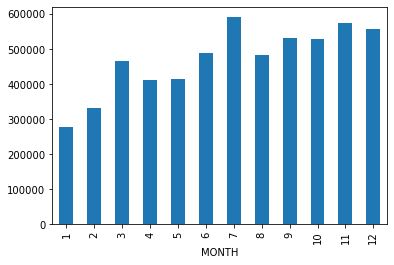

In [248]:
merged_data.groupby("MONTH").sum()['TARGET'].plot.bar()#1월과 2월이 특히 낮다

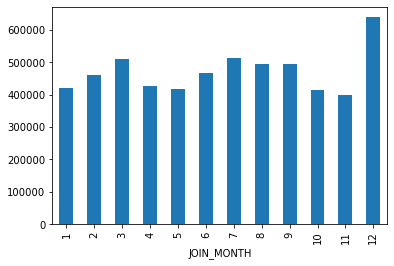

In [257]:
lst = []
for i in merged_data['JOIN_DATE']:
    lst.append(i.month)
merged_data['JOIN_MONTH'] = lst

merged_data.groupby("JOIN_MONTH").sum()['TARGET'].plot.bar() #12월이 특히 높다

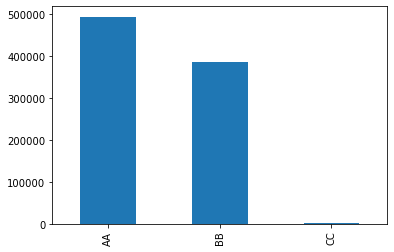

In [249]:
merged_data['D_TYPE'].value_counts().plot.bar() #CC가 적다

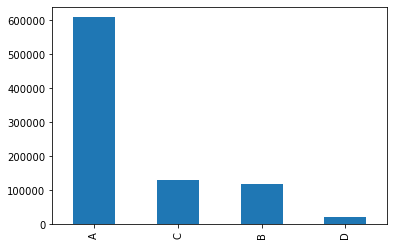

In [250]:
merged_data['GOODS_TYPE'].value_counts().plot.bar() #A가 많다

In [ ]:
#D_TYPE,AD1이 무엇을 의미하는 것인가

In [95]:
dct = {}
for i in db_data.values:
    if i[0] in dct.keys():        
        pd.concat([dct[i[0]],pd.DataFrame(i[1:])],axis=1)
    else:
        dct[i[0]] = pd.DataFrame(i[1:])


In [97]:
train_dct = {}
for i in train_data.values:
    if i[0] in dct.keys():        
        pd.concat([dct[i[0]],pd.DataFrame(i[1:])],axis=1)
    else:
        dct[i[0]] = pd.DataFrame(i[1:])


In [98]:
test_dct = {}
for i in test_data.values:
    if i[0] in dct.keys():        
        pd.concat([dct[i[0]],pd.DataFrame(i[1:])],axis=1)
    else:
        dct[i[0]] = pd.DataFrame(i[1:])


In [100]:
db_data.groupby("USER_ID").count()

,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
USER_ID,,,,,,,
224,2,2,2,2,2,2,2
232,23,23,23,23,23,23,23
342,1,1,1,1,1,1,1
565,2,2,2,2,2,2,2
729,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
1830551,1,1,1,1,1,1,1
1830570,1,1,1,1,1,1,1
1830580,1,1,1,1,1,1,1


# train_test split

In [4]:
train_data = db_data.query('DATE<20201001')

In [5]:
test_data = db_data.query('DATE>=20201001') #datetime을 query로 부를 경우에는 2020-01-01이 아니라 20200101로 넣어야 되는구나

In [152]:
train_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [153]:
test_data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR
623582,81772,2015-05-02,BB,204438,A,2020-10-01,1,DJ
623583,92258,2015-05-24,AA,220745,A,2020-10-01,1,SD


2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값

요일별 이용량에 대한 분석 - EDA

유저별 이용 count 값에 대한 분석 - EDA